# Evaluation of experimentally evidenced susceptible reactions 

In [2]:
# Import packages

import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.io import read_sbml_model
import os
import numpy as np
import re
from collections import Counter

In [3]:
# Load refined model
ros = read_sbml_model("/home/jorgexd/ROS/ros_model.xml")
ros.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.002594,0,0.00%
cl_e,EX_cl_e,0.002594,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001866,0,0.00%
cu2_e,EX_cu2_e,0.001729,0,0.00%
fe2_e,EX_fe2_e,0.009015,0,0.00%
glc__D_e,EX_glc__D_e,6.3,6,99.99%
k_e,EX_k_e,0.0973,0,0.00%
mg2_e,EX_mg2_e,0.004324,0,0.00%
mn2_e,EX_mn2_e,0.001729,0,0.00%
mobd_e,EX_mobd_e,0.002003,0,0.00%


In [4]:
# Load full dataset
ros_table = pd.read_csv("/home/jorgexd/ROS/ROS_summary_BRENDA_full.tsv", sep = '\t', encoding='latin1')
ros_table.head()

,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0243,Q88R90,gshA,Glutamate--cysteine ligase,0,0.00,0,0,0.00,0,0,0.0,NaN,S_Glutamate_Metabolism,Reduction of disulfide bonds lead to the inact...,Arabidopsis Thaliana,6.3.2.2,Ligases,NaN,NaN
1,PP_0808,Q88PP0,hmp,Flavohemoprotein,1,4.51,0,8,5.11,0,0,0.0,heme b (C34H30FeN4O4),S_Nitrogen_Metabolism,BRENDA,Bovine,1.14.12.17,Oxidoreductases,NaN,NaN
2,PP_5228,Q88CF3,dapF,Diaminopimelate epimerase,2,6.14,2,4,4.72,0,0,0.0,NaN,S_Lysine_Metabolism,When CgDapF was treated with various concentra...,Corynebacterium glutamicum,5.1.1.7,Isomerases,NaN,NaN
3,PP_0915,Q88PD5,sodB,Superoxide dismutase [Fe],0,0.00,0,3,4.23,0,0,0.0,Fe cation (Fe),Unassigned,Gradual inactivation of the enzyme due to ROS ...,E.coli,1.15.1.1,Oxidoreductases,"An, S.S.; Kim, Y.M.: Purification and charact...",Stemona tuberosa AND Marinomonas sp. AND Homo ...
4,PP_0415,Q88QS3,rpe,Ribulose-phosphate 3-epimerase,0,5.13,0,2,5.95,0,0,0.0,Co(2+) (Co) AND Fe(2+) (Fe) AND Mn(2+) (Mn) AN...,S_Pentose_Phosphate_Pathway,"Easily affected by ROS, although this effect c...",E.coli,5.1.3.1,Isomerases,NaN,NaN


In [5]:
# Load susceptible dataset 
susceptible_table = pd.read_csv('/home/jorgexd/ROS/Pputida_evidenced.txt', sep = '\t', encoding = 'latin1')

susceptible_enz = susceptible_table["KEGG ID"].tolist()

susceptible_table.head()

,KEGG ID,UniProt ID,Gene,Protein,# SR in AS,Mean SR - AS minimum distance,cys in AS,# SR in BS,Mean SR - BS minimum distance,cys in BS,# Disulfide bonds,Mean S-S - AS/BS minimum distance,Cofactor,Subsystem,Evidence,Study organism,ecNumber,EC class,BRENDA evidence,BRENDA organism
0,PP_0732,Q88PW6,hemA,Glutamyl-tRNA reductase,1,3.83,1,6,4.85,1,0,0.0,NaN,S_Cofactor_and_Prosthetic_Group_Biosynthesis__...,BRENDA,NaN,1.2.1.70,Oxidoreductases,suggesting that cysteine residues are the prim...,Acidithiobacillus ferrooxidans
1,PP_4715,Q88DV4,tpiA,Triosephosphate isomerase,1,4.37,0,1,5.10,0,0,0.0,NaN,S_Gluconeogenesis,BRENDA,NaN,5.3.1.1,Isomerases,oxidation of cystein residues,Arabidopsis thaliana AND Chlamydomonas reinhar...
2,PP_3668,Q88GQ0,katG,Catalase-peroxidase,1,3.86,0,2,5.24,0,0,0.0,heme b (C34H30FeN4O4),Unassigned,BRENDA,NaN,1.11.1.21,Oxidoreductases,"Steinman, H.M.; Fareed, F.; Weinstein, L.: Ca...",Archaeoglobus fulgidus AND Rhodobacter capsula...
3,PP_1001,Q88P52,arcA,Arginine deiminase,1,3.87,1,0,0.00,0,0,0.0,NaN,S_Arginine_and_Proline_Metabolism,BRENDA,NaN,3.5.3.6,Hydrolases,oxidation of cystein residues,Aspergillus nidulans
4,PP_0398,Q88QT9,glpE,Thiosulfate sulfurtransferase GlpE,1,3.85,1,0,0.00,0,0,0.0,NaN,S_Sulfur_Metabolism,BRENDA,NaN,2.8.1.1,Transferases,"In the absence of reduced thioredoxin, the sul...",Bos taurus


In [6]:
# Get only those reactions having all its enzymes affected
to_knock = []
pattern = r'PP_\d{4}'

reactions_gpr = {}
for rxn in ros.reactions:
    matches = re.findall(pattern, str(rxn.gpr))
    if matches:
        reactions_gpr[rxn.id] = matches

for reaction, gprs in reactions_gpr.items():
    if set(gprs).issubset(set(susceptible_enz)):
        print(gprs)
        to_knock.append(reaction)
        print(f'\nReaction {reaction} is inhibited by ROS')
        print(ros.reactions.get_by_id(reaction))

['PP_3433']

Reaction 34HPPOR is inhibited by ROS
34HPPOR: 34hpp_c + o2_c --> co2_c + hgentis_c
['PP_2339', 'PP_2112']

Reaction ACONTb is inhibited by ROS
ACONTb: acon_C_c + h2o_c <=> icit_c
['PP_1001']

Reaction ARGDr is inhibited by ROS
ARGDr: arg__L_c + h2o_c --> citr__L_c + nh4_c
['PP_0115', 'PP_3668']

Reaction CAT is inhibited by ROS
CAT: 2.0 h2o2_c --> 2.0 h2o_c + o2_c
['PP_3166', 'PP_3713']

Reaction CATDOX is inhibited by ROS
CATDOX: catechol_c + o2_c --> ccmuac_c + 2.0 h_c
['PP_1010']

Reaction EDD is inhibited by ROS
EDD: 6pgc_c --> 2ddg6p_c + h2o_c
['PP_0328']

Reaction FALDM is inhibited by ROS
FALDM: 2.0 fald_c + h2o_c <=> for_c + h_c + meoh_c
['PP_2518']

Reaction GADOX is inhibited by ROS
GADOX: ga_c + o2_c --> 2.0 h_c + omaketo_c
['PP_0732']

Reaction GLUTRR is inhibited by ROS
GLUTRR: glutrna_c + h_c + nadph_c --> glu1sa_c + nadp_c + trnaglu_c
['PP_1874', 'PP_1686', 'PP_0777']

Reaction GTHPi is inhibited by ROS
GTHPi: 2.0 gthrd_c + h2o2_c --> gthox_c + 2.0 h2o_c
['P

In [7]:
# Knockout individual genes directly
from cobra.flux_analysis import single_gene_deletion

deletions = single_gene_deletion(ros, susceptible_enz)
print(deletions)

           ids        growth   status
0    {PP_1308}  6.138368e-01  optimal
1   {pWW0_097}  6.138368e-01  optimal
2    {PP_3433}  6.138368e-01  optimal
3    {PP_3942}  6.138368e-01  optimal
4    {PP_2518}  6.138368e-01  optimal
5    {PP_4012}  6.138368e-01  optimal
6    {PP_5228}  6.138368e-01  optimal
7    {PP_0481}  6.138368e-01  optimal
8    {PP_4264}  6.138368e-01  optimal
9    {PP_0946}  6.138368e-01  optimal
10   {PP_2336}  6.138368e-01  optimal
11   {PP_1874}  6.138368e-01  optimal
12   {PP_4116}  6.138368e-01  optimal
13   {PP_4187}  6.138368e-01  optimal
14   {PP_0415}  6.137837e-01  optimal
15   {PP_0823}  6.138368e-01  optimal
16   {PP_2339}  6.138368e-01  optimal
17   {PP_4715}  6.134872e-01  optimal
18   {PP_1001}  6.138368e-01  optimal
19   {PP_0115}  6.138368e-01  optimal
20   {PP_1009}  6.138368e-01  optimal
21   {PP_4011}  6.138368e-01  optimal
22   {PP_1686}  6.138368e-01  optimal
23   {PP_0915}  6.138368e-01  optimal
24   {PP_0398}  6.138368e-01  optimal
25   {PP_514

In [8]:
import matplotlib.pyplot as plt

def plot_knockouts(deletions, model, color = 'skyblue', figsize=(20,5), save = False):
    "Plots bar plot with the objective value after carrying out specific deletions"
    obj_value = model.summary()._objective_value

    ids = deletions["ids"].tolist()
    formatted_ids = []
    for i in ids:
        string = str(i)
        formatted_ids.append(string.replace('{', '').replace('}', '').replace('\'', ''))

    growth = deletions["growth"].tolist()

    plt.figure(figsize=figsize)  
    plt.bar(formatted_ids, growth, color=color)  
    plt.axhline(y=obj_value, color='red', linestyle='--', linewidth=1, label=f'Wild-type growth ({obj_value:.2f})')
    plt.xlabel('Genes')  
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Growth')    
    plt.title('Individual knockout of genes') 
    plt.tight_layout()

    if save:
        plt.savefig("gene_knockouts.svg", bbox_inches="tight")

    plt.show()
    
def plot_knockouts_vertical(deletions, model, color='skyblue', figsize=(8, 12), save=False):
    """Plots horizontal bar plot with the objective value after carrying out specific deletions"""
    
    deletions = deletions.sort_values("growth")
    obj_value = model.summary()._objective_value

    ids = deletions["ids"].tolist()
    formatted_ids = []
    for i in ids:
        string = str(i)
        formatted_ids.append(string.replace('{', '').replace('}', '').replace('\'', ''))

    growth = deletions["growth"].tolist()

    plt.figure(figsize=figsize)
    plt.barh(formatted_ids, growth, color=color)
    plt.axvline(x=obj_value, color='red', linestyle='--', linewidth=1,
                label=f'Wild-type growth ({obj_value:.2f})')

    plt.ylabel('Genes')
    plt.xlabel('Growth')
    plt.title('Individual knockout of genes')
    plt.legend()
    plt.tight_layout()

    if save:
        plt.savefig("gene_knockouts_horizontal.svg", bbox_inches="tight")


def get_knockouts(deletions, model, effect='deletereous'):
    """Retrieves genes that are deletereous or problematic (reduce objective value) when knocked out"""

    if effect == 'deletereous':
        essential_rxns = deletions[deletions["growth"] < 0.00001]

    elif effect == 'problematic':
        obj_value = model.summary()._objective_value
        essential_rxns = deletions[(deletions["growth"] < obj_value - 0.01 ) & (deletions["growth"] > 0.00001)]

    else:
        print(f'Error: invalid effect {effect}')
        return []
        
    essential_rxns_ids = essential_rxns["ids"]
    essentials = []

    for eri in essential_rxns_ids:
        string = str(eri)
        essentials.append(string.replace('{', '').replace('}', '').replace('\'', ''))

    for es in essentials:
        gene = ros.genes.get_by_id(es)
        reactions = gene.reactions
        print(gene)
        for rxn in reactions:
            print(rxn)
        print('')

    return essentials

essentials = get_knockouts(deletions, ros)


PP_5141
TMDS: dump_c + mlthf_c --> dhf_c + dtmp_c

PP_1231
QULNS_ROS: dhap_c + iasp_c + 1.005 nadh_c + 0.005 o2_c --> 0.005 h2o2_c + 2.0 h2o_c + 1.015 h_c + 1.005 nad_c + pi_c + quln_c

PP_0732
GLUTRR: glutrna_c + h_c + nadph_c --> glu1sa_c + nadp_c + trnaglu_c



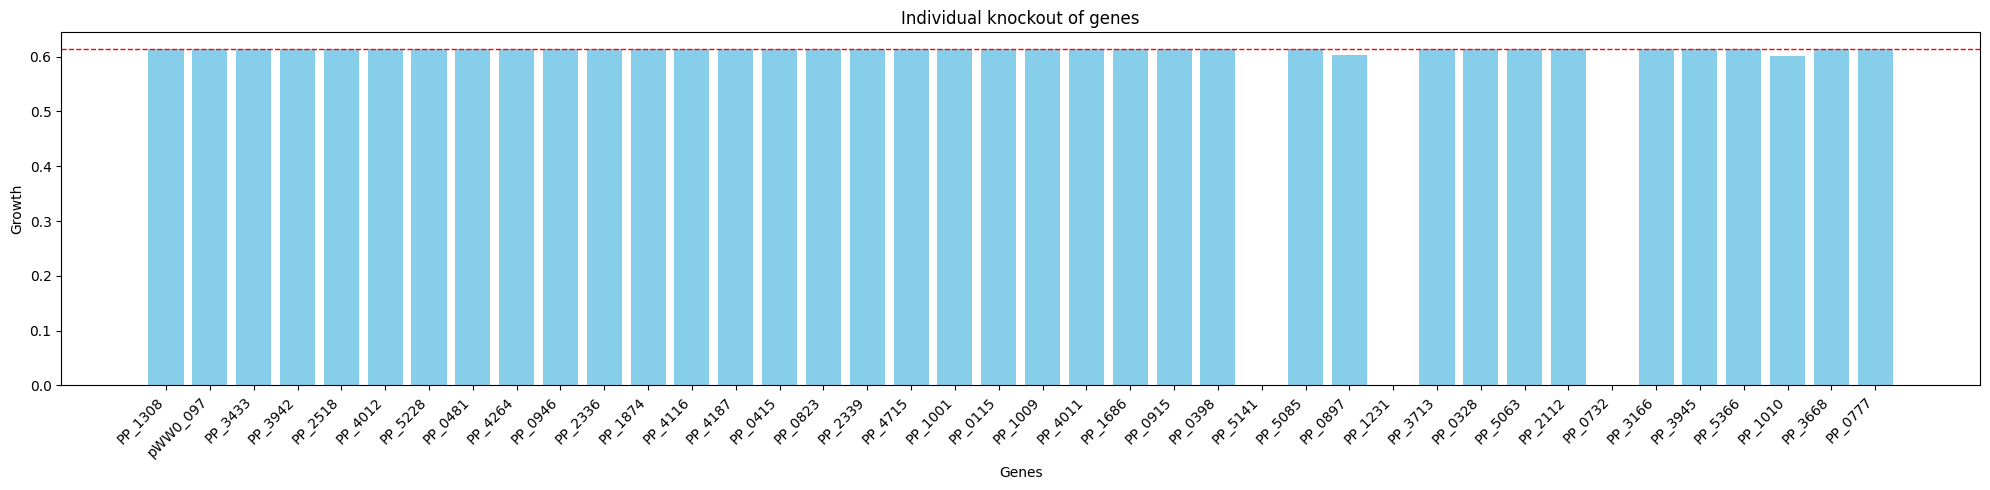

In [9]:
# Plot knockouts
plot_knockouts(deletions, ros, save = True)

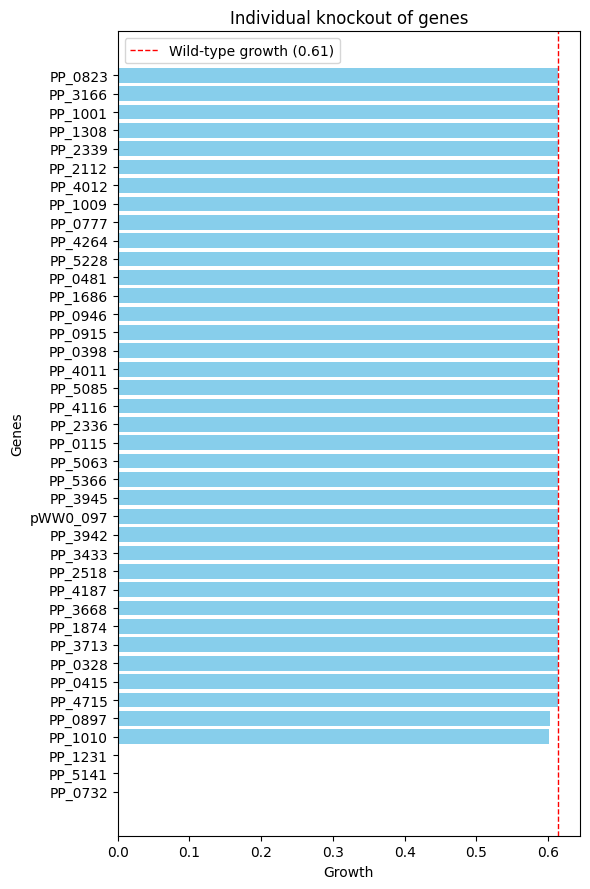

In [35]:
plot_knockouts_vertical(deletions, ros, figsize=(6,9), save = True)

In [10]:
# Get deletereous reactions
deletereous = get_knockouts(deletions, ros, 'deletereous')

PP_5141
TMDS: dump_c + mlthf_c --> dhf_c + dtmp_c

PP_1231
QULNS_ROS: dhap_c + iasp_c + 1.005 nadh_c + 0.005 o2_c --> 0.005 h2o2_c + 2.0 h2o_c + 1.015 h_c + 1.005 nad_c + pi_c + quln_c

PP_0732
GLUTRR: glutrna_c + h_c + nadph_c --> glu1sa_c + nadp_c + trnaglu_c



In [11]:
print('The following susceptible proteins are critical for organism survival:')
for gene in deletereous:
    genename = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Protein"].iloc[0]
    subsystem = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Subsystem"].iloc[0]
    print(f'{gene} : {genename} ({subsystem})')

The following susceptible proteins are critical for organism survival:
PP_5141 : Thymidylate synthase (S_Pyrimidine_Metabolism)
PP_1231 : Quinolinate synthase (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Nicotinamide_Biosynthesis)
PP_0732 : Glutamyl-tRNA reductase (S_Cofactor_and_Prosthetic_Group_Biosynthesis__Porphyrin_and_Chlorophyll_Metabolism)


In [12]:
# Get problematic reactions
problematic = get_knockouts(deletions, ros, 'problematic')

PP_0897
FUM_ROS_R: 0.004 h_c + mal__L_c + 0.005 nadh_c + 0.005 o2_c --> fum_c + 0.004545 h2o2_c + h2o_c + 0.005 nad_c + 0.0004545 o2s_c
FUM_ROS_F: fum_c + h2o_c + 0.005 h_c + 0.005 nadh_c + 0.005 o2_c --> 0.004545 h2o2_c + mal__L_c + 0.005 nad_c + 0.0004545 o2s_c

PP_1010
EDD: 6pgc_c --> 2ddg6p_c + h2o_c



In [13]:
print('The following susceptible proteins have an impact on the organism survival:')
for gene in problematic:
    genename = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Protein"].iloc[0]
    subsystem = susceptible_table.loc[susceptible_table["KEGG ID"] == gene, "Subsystem"].iloc[0]
    print(f'{gene} : {genename} ({subsystem})')

The following susceptible proteins have an impact on the organism survival:
PP_0897 : Fumarate hydratase class I (S_TCA_Cycle)
PP_1010 : Phosphogluconate dehydratase (S_Glycolysis)


### Subsystems evaluation and grouping

In [14]:
def extract_subsystems(ros_table, ident):
    subsystems = []
    subsystem = ros_table.loc[ros_table["KEGG ID"] == ident, "Subsystem"].iloc[0]
    all_subsystems = subsystem.split(' AND ')
    
    for ss in all_subsystems:
        refined_subsystem = ss.split('__')[0].replace('S_', '').replace('_',' ')
        subsystems.append(refined_subsystem)

    return subsystems

In [15]:
print(reactions_gpr)

{'3HAD160': ['PP_1602', 'PP_4174'], '15DAPabcpp': ['PP_5181', 'PP_5179', 'PP_5178', 'PP_5177'], '1P2CBXLR': ['PP_3591'], '1PPDCRc': ['PP_3591'], '1PY4h3cAH': ['PP_1257'], '23CTI1': ['PP_2136'], '23CTI2': ['PP_2136'], '23CTI3': ['PP_2136'], '2AACLPGT160': ['PP_1700'], '2AACLPGT161': ['PP_1700'], '2AACLPGT180': ['PP_1700'], '2AACLPGT181': ['PP_1700'], '2AACLPPEAT160': ['PP_1700'], '2AACLPPEAT161': ['PP_1700'], '2AACLPPEAT180': ['PP_1700'], '2AACLPPEAT181': ['PP_1700'], '2AGPE160tipp': ['PP_1700'], '2AGPE161tipp': ['PP_1700'], '2AGPE180tipp': ['PP_1700'], '2AGPE181tipp': ['PP_1700'], '2AGPG160tipp': ['PP_1700'], '2AGPG161tipp': ['PP_1700'], '2AGPG180tipp': ['PP_1700'], '2AGPG181tipp': ['PP_1700'], '2DHGLCK': ['PP_3378'], '2DHGLCNkt_tpp': ['PP_3377'], '34HPPOR': ['PP_3433'], '3AIBT2': ['PP_0596'], '3HAACOAT100': ['PP_1408'], '3HAACOAT120': ['PP_1408'], '3HAACOAT121': ['PP_1408'], '3HAACOAT140': ['PP_1408'], '3HAACOAT141': ['PP_1408'], '3HAACOAT60': ['PP_1408'], '3HAACOAT80': ['PP_1408'], '

In [16]:
# Cant access subsystem directly from reactions
# Use the evidence table
subsystems = []

for rxn_name, gpr in reactions_gpr.items():
    if rxn_name in to_knock:
        rxn_subsystems = []
        for ID in gpr:
            ss = extract_subsystems(ros_table, ID)
            rxn_subsystems.extend(ss)
        
        rxn_subsystems = list(set(rxn_subsystems))
        subsystems.extend(rxn_subsystems)

print(subsystems)
        

        

['Aromatic Compounds Degradation', 'TCA Cycle', 'Arginine and Proline Metabolism', 'Unassigned', 'Aromatic Compounds Degradation', 'Glycolysis', 'Formaldehyde Metabolism', 'Aromatic Compounds Degradation', 'Cofactor and Prosthetic Group Biosynthesis', 'Unassigned', 'TCA Cycle', 'TCA Cycle', 'Aromatic Compounds Degradation', 'TCA Cycle', 'Methionine Metabolism', 'Alternate Carbon', 'Aromatic Compounds Degradation', 'Pentose Phosphate Pathway', 'Unassigned', 'Pyrimidine Metabolism', 'Gluconeogenesis', 'Alternate Carbon and Nitrogen source', 'Alternate Carbon and Nitrogen source', 'TCA Cycle', 'TCA Cycle', 'Cofactor and Prosthetic Group Biosynthesis', 'TCA Cycle', 'TCA Cycle', 'TCA Cycle', 'Glycine', 'TCA Cycle', 'Glycine', 'Cofactor and Prosthetic Group Biosynthesis', 'Unassigned']


In [17]:
# Count occurrences of each subsystem in susceptible reactions
        
subs_count = Counter(subsystems)
print(subs_count)

Counter({'TCA Cycle': 10, 'Aromatic Compounds Degradation': 5, 'Unassigned': 4, 'Cofactor and Prosthetic Group Biosynthesis': 3, 'Alternate Carbon and Nitrogen source': 2, 'Glycine': 2, 'Arginine and Proline Metabolism': 1, 'Glycolysis': 1, 'Formaldehyde Metabolism': 1, 'Methionine Metabolism': 1, 'Alternate Carbon': 1, 'Pentose Phosphate Pathway': 1, 'Pyrimidine Metabolism': 1, 'Gluconeogenesis': 1})


In [18]:
peri_enriched = ['Alternate Carbon and Nitrogen Source', 'Fatty Acids Metabolism', 'Aromatic Compounds Degradation', \
 'Alternate Carbon Source', 'Xenobiotic Tolerance', 'Nitrogen Metabolism']

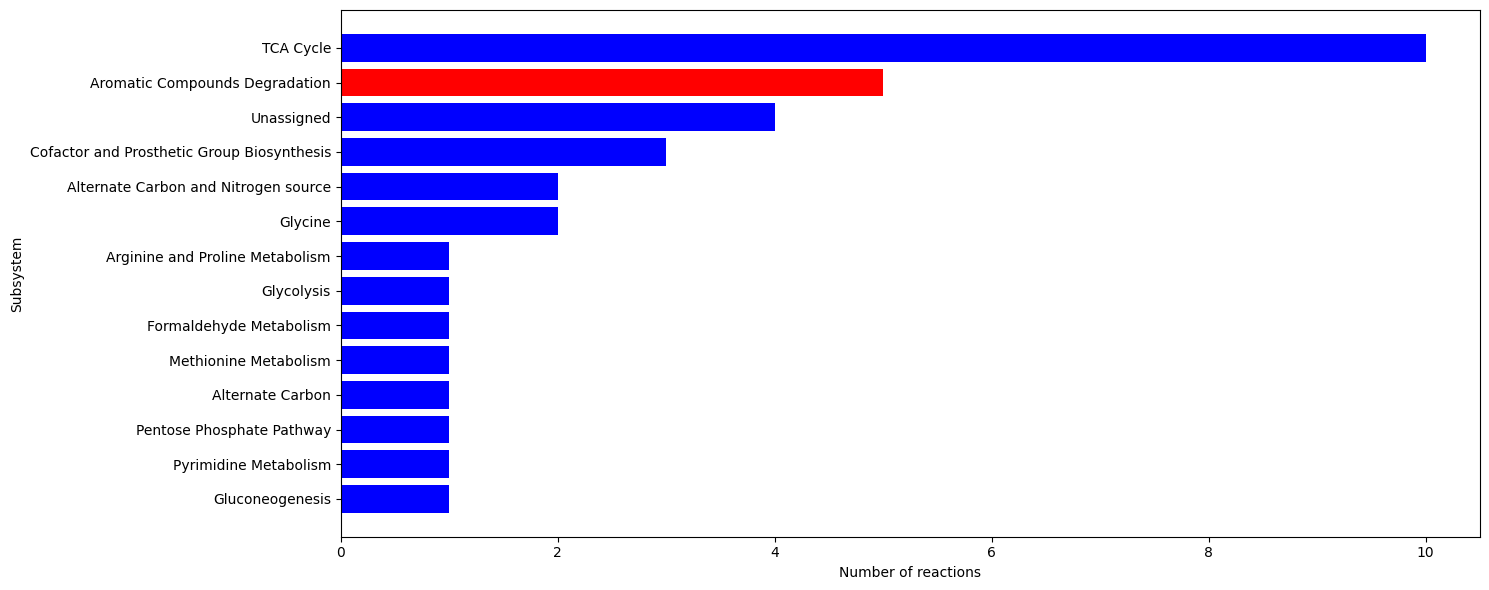

In [19]:
# Plot the results
import matplotlib.pyplot as plt

# Order
top_th = 20
top = subs_count.most_common(top_th)
labels, values = zip(*top)

# Colors
colors = [
    "red" if l in peri_enriched else "blue"
    for l in labels
]

# Plot
plt.figure(figsize=(15, 6))
plt.barh(labels[::-1], values[::-1], color=colors[::-1])
plt.xlabel("Number of reactions")
plt.ylabel("Subsystem")
plt.tight_layout()

plt.savefig("subsystmes.svg", bbox_inches="tight")

plt.show()

__Enrichment analysis in each subset__

In [20]:
# Extract no susceptible dataset
no_susceptible_table = ros_table[~ros_table["UniProt ID"].isin(susceptible_table["UniProt ID"])]
no_susceptible_table.shape

(968, 20)

In [21]:
# Store the subsystem for each reaction in susceptible data and no susceptible data separatedly
from collections import defaultdict

susceptible_subsystems = []
no_susceptible_subsystems = []
subsystems_reactions = defaultdict(list)

susceptible_ids = susceptible_table["KEGG ID"].tolist()
no_susceptible_ids = no_susceptible_table["KEGG ID"].tolist()

for rxn_name, gpr in reactions_gpr.items():

    # Reaction is susceptible
    if rxn_name in to_knock:
        rxn_subsystems = []
        for ID in gpr:
            ss = extract_subsystems(susceptible_table, ID)
            rxn_subsystems.extend(ss)
        
        rxn_subsystems = list(set(rxn_subsystems))
        susceptible_subsystems.extend(rxn_subsystems)

        for rs in rxn_subsystems:
            subsystems_reactions[rs].append(rxn_name)

            

    # Reaction is not susceptible (contains at least 1 no susceptible enzyme)
    else:
        rxn_subsystems = []
        for ID in gpr:
            try:
                ss = extract_subsystems(no_susceptible_table, ID)
            except:
                ss = []  # ID is 
            rxn_subsystems.extend(ss)
        
        rxn_subsystems = list(set(rxn_subsystems))
        no_susceptible_subsystems.extend(rxn_subsystems)

        for rs in rxn_subsystems:
            subsystems_reactions[rs].append(rxn_name)


In [22]:
print(susceptible_subsystems)
print(no_susceptible_subsystems)

['Aromatic Compounds Degradation', 'TCA Cycle', 'Arginine and Proline Metabolism', 'Unassigned', 'Aromatic Compounds Degradation', 'Glycolysis', 'Formaldehyde Metabolism', 'Aromatic Compounds Degradation', 'Cofactor and Prosthetic Group Biosynthesis', 'Unassigned', 'TCA Cycle', 'TCA Cycle', 'Aromatic Compounds Degradation', 'TCA Cycle', 'Methionine Metabolism', 'Alternate Carbon', 'Aromatic Compounds Degradation', 'Pentose Phosphate Pathway', 'Unassigned', 'Pyrimidine Metabolism', 'Gluconeogenesis', 'Alternate Carbon and Nitrogen source', 'Alternate Carbon and Nitrogen source', 'TCA Cycle', 'TCA Cycle', 'Cofactor and Prosthetic Group Biosynthesis', 'TCA Cycle', 'TCA Cycle', 'TCA Cycle', 'Glycine', 'TCA Cycle', 'Glycine', 'Cofactor and Prosthetic Group Biosynthesis', 'Unassigned']
['Fatty Acid', 'Cofactor and Prosthetic Group Biosynthesis', 'Transport', 'Lysine Metabolism', 'Alternate Carbon and Nitrogen source', 'Lysine Metabolism', 'Alternate Carbon and Nitrogen source', 'Alternate Ca

In [23]:
susc_subsystem_count = Counter(susceptible_subsystems)
no_susc_subsystem_count = Counter(no_susceptible_subsystems)

all_subsystems = susceptible_subsystems + no_susceptible_subsystems
all_subsystems = set(all_subsystems)

print(len(all_subsystems))

47


In [24]:
print(susc_subsystem_count)

Counter({'TCA Cycle': 10, 'Aromatic Compounds Degradation': 5, 'Unassigned': 4, 'Cofactor and Prosthetic Group Biosynthesis': 3, 'Alternate Carbon and Nitrogen source': 2, 'Glycine': 2, 'Arginine and Proline Metabolism': 1, 'Glycolysis': 1, 'Formaldehyde Metabolism': 1, 'Methionine Metabolism': 1, 'Alternate Carbon': 1, 'Pentose Phosphate Pathway': 1, 'Pyrimidine Metabolism': 1, 'Gluconeogenesis': 1})


In [25]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

enrich_analysis_results = []

b = len(susceptible_subsystems)
d = len(no_susceptible_subsystems)

for subsystem in all_subsystems:

    try:
        a = susc_subsystem_count[subsystem]
        c = no_susc_subsystem_count[subsystem]
    
    except:
        continue


    cont_table = np.array([[a, b],[c,d]])  # Contingency table

    oddsratio, pvalue = fisher_exact(cont_table, alternative = "greater")

    subsystem_name = subsystem.replace('S_', '').replace('_', ' ')

    enrich_analysis_results.append({
            "subsystem": subsystem_name,
            "evidenced": a,
            "no_evidenced": c,
            "oddsratio": oddsratio,
            "pvalue": pvalue
        })


In [26]:
enrich_df = pd.DataFrame(enrich_analysis_results)
enrich_df

,subsystem,evidenced,no_evidenced,oddsratio,pvalue
0,TCA Cycle,10,10,79.205882,6.168673e-14
1,Iron uptake and metabolism,0,24,0.000000,1.000000e+00
2,Unassigned,4,38,8.337461,2.323783e-03
3,Histidine Metabolism,0,13,0.000000,1.000000e+00
4,Murein Recycling,0,2,0.000000,1.000000e+00
5,Oxidative Phosphorylation,0,4,0.000000,1.000000e+00
6,PHAs Metabolism,0,220,0.000000,1.000000e+00
7,Nucleotide Salvage Pathway,0,8,0.000000,1.000000e+00
8,Glycerophospholipid Metabolism,0,116,0.000000,1.000000e+00
9,Sulfur Metabolism,0,28,0.000000,1.000000e+00


In [27]:
# Benjamini–Hochberg (FDR) correction
enrich_df = pd.DataFrame(enrich_analysis_results)
enrich_df["p_adj"] = multipletests(
    enrich_df["pvalue"],
    method = "fdr_bh"
)[1]

enrich_df

,subsystem,evidenced,no_evidenced,oddsratio,pvalue,p_adj
0,TCA Cycle,10,10,79.205882,6.168673e-14,2.899276e-12
1,Iron uptake and metabolism,0,24,0.000000,1.000000e+00,1.000000e+00
2,Unassigned,4,38,8.337461,2.323783e-03,5.460890e-02
3,Histidine Metabolism,0,13,0.000000,1.000000e+00,1.000000e+00
4,Murein Recycling,0,2,0.000000,1.000000e+00,1.000000e+00
5,Oxidative Phosphorylation,0,4,0.000000,1.000000e+00,1.000000e+00
6,PHAs Metabolism,0,220,0.000000,1.000000e+00,1.000000e+00
7,Nucleotide Salvage Pathway,0,8,0.000000,1.000000e+00,1.000000e+00
8,Glycerophospholipid Metabolism,0,116,0.000000,1.000000e+00,1.000000e+00
9,Sulfur Metabolism,0,28,0.000000,1.000000e+00,1.000000e+00


In [28]:
# Print only significant values
significant = enrich_df[enrich_df["p_adj"] <= 0.05]
significant

,subsystem,evidenced,no_evidenced,oddsratio,pvalue,p_adj
0,TCA Cycle,10,10,79.205882,6.168673e-14,2.899276e-12


In [29]:
print(subsystems_reactions['Unassigned'])

['AMID4', 'APSR', 'APSR2', 'CAT', 'CATpp', 'CCPpp', 'DHMPTRx', 'GRXR', 'GTHOr', 'GTHPi', 'H2CO3D', 'HCO3E', 'METSOXR1', 'METSOXR2', 'PAPSR', 'PAPSR2', 'PPCSCT', 'RNDR1', 'RNDR2', 'RNDR3', 'RNDR4', 'SELNPS', 'TDSR1', 'TDSR2', 'THIORDXi', 'TNTR1x', 'METNA', 'MTSOXINACT', 'PPTRNACT', 'ADSELR', 'ADSELR2', 'BALAMDAH', 'CYTOM', 'DSBCGT', 'DSBDR', 'DSBGGT', 'ASCT', 'GHBDHx', 'RDXR_ROS_F', 'NADH5_ROS', 'NADPHQR2_ROS', 'SPODM_ROS']
